# 01 Sensitivity analysis of model parameters

## A. Imports

In [80]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from prettytable import PrettyTable

Add translation to the `sys.path`:

In [2]:
import sys
sys.path.append(r'../')
sys.path.append(r'../translation/')

In [3]:
import translation

## B. Ribosomes

In [15]:
filepath =  {150000: "../results/updated Shah transcriptome, full exome, no decay, updated initiation "
             "rates according to Shah, ribosomes factor 0.75_20211109_0347_150000_ribosomes_3600s.p",
             200000: "../results/updated Shah transcriptome, full exome, no decay, updated initiation "
             "rates according to Shah_20211109_0858_200000_ribosomes_3600s.p",
             250000: "../results/updated Shah transcriptome, full exome, no decay, updated initiation "
             "rates according to Shah, ribosomes factor 1.25_20211108_2333_250000_ribosomes_3600s.p"}

Load results from file:

In [16]:
results = {}

for nribo in filepath:
    print(filepath[nribo])
    with open(filepath[nribo], 'rb') as f:
        results[nribo] = pickle.load(f)

../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah, ribosomes factor 0.75_20211109_0347_150000_ribosomes_3600s.p
../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20211109_0858_200000_ribosomes_3600s.p
../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah, ribosomes factor 1.25_20211108_2333_250000_ribosomes_3600s.p


In [18]:
results[150000].keys()

dict_keys(['proteome', 'peptide_bonds', 'transcriptome', 'timerange', 'timecourses', 'description', 'time_stamp', 'n_ribosomes', 'n_tRNA', 'duration'])

In [20]:
results[150000]['peptide_bonds']

1285720976

In [21]:
len(results[150000]['transcriptome'])

57508

Define protein names:

In [33]:
protnames = {}
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein', 'peptide_bonds']

for nribo in results.keys():
    print(nribo)
    protnames[nribo] = results[nribo]['timecourses'].keys()
    for fragment in blacklist:
        protnames[nribo] = [name for name in protnames[nribo] if fragment not in name]

150000
200000
250000


Define protein speeds:

In [45]:
prot_speeds = {}

for nribo in results.keys():
    print(nribo)
    prot_speeds[nribo] = {}
    for prot in protnames[nribo]:
        start, stop = 599, len(results[nribo]['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
        prot_speeds[nribo][prot] = (results[nribo]['timecourses'][prot][stop] - results[nribo]['timecourses'][prot][start]) / \
        (1.0 * results[nribo]['timerange'][stop] - results[nribo]['timerange'][start])
        if prot_speeds[nribo][prot] > 25: 
            print(prot, prot_speeds[nribo][prot])

150000
YKL060C 28.761064425770304
YLR044C 38.547899159663864
200000
YJL189W 27.007282913165263
YKL152C 25.215406162464983
YKL060C 31.57787114845938
YOL086C 25.554699645653297
YAL038W 27.388515406162462
YLR044C 42.53949579831932
250000
YJL189W 28.892156862745093
YLR110C 26.039495798319326
YKL152C 27.07899159663865
YKL060C 33.71708683473389
YOL086C 27.364248799002784
YCR012W 26.57394957983193
YAL038W 29.31428571428571
YLR044C 45.90504201680672


In [49]:
transcriptome_shah = pickle.load(open('../parameters/transcriptome_shah.p', 'rb'))

In [56]:
prot_per_transcript_speeds = {}

for nribo in results.keys():
    print(nribo)
    prot_per_transcript_speeds[nribo] = {}
    for prot in protnames[nribo]:
        start, stop = 599, len(results[nribo]['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
        prot_per_transcript_speeds[nribo][prot] = (results[nribo]['timecourses'][prot][stop] - results[nribo]['timecourses'][prot][start]) / \
            transcriptome_shah[prot] / (1.0 * results[nribo]['timerange'][stop] - results[nribo]['timerange'][start])
        if prot_per_transcript_speeds[nribo][prot] > 0.05: 
            print(prot, prot_per_transcript_speeds[nribo][prot])

150000
YDR461W 0.053068500127323656
YLR388W 0.05006672826198542
200000
YDR461W 0.057431457431457424
YLR388W 0.054819833692639354
YDR224C 0.05267884931750478
YJL158C 0.05085200746965452
250000
YDR461W 0.06231219760631525
YJL189W 0.052340863881784584
YLR388W 0.05866660800445832
YDR224C 0.055404383975812536
YFL014W 0.050606909430438836
YJL158C 0.05416083099906628


In [66]:
def plot_speed_efficiency(prot_speeds, prot_per_transcript_speeds):
    plt.rcParams['figure.figsize'] = (12, 5)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'grey'

    fig = plt.figure()
    fig.subplots_adjust(wspace=0.35)

    ax = fig.add_subplot(121)
    n, bins, patches = ax.hist(prot_speeds.values(), 
                               bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                      np.log10(max(prot_speeds.values())), 25), 
                               edgecolor='white')
    ax.set_xscale("log")
    ax.set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
    ax.set_xlabel('Translation speed [proteins/s]', fontsize=16)
    ax.set_ylabel('Protein count', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    plt.text(0.0001, 670, "A", fontsize=16, weight="bold")

    ax = fig.add_subplot(122)
    n, bins, patches = ax.hist(prot_per_transcript_speeds.values(), 
                               bins = 10**np.linspace(np.log10(min(prot_per_transcript_speeds.values())+0.0001), 
                                                      np.log10(max(prot_per_transcript_speeds.values())), 32), 
                               edgecolor='white')
    ax.set_xscale("log")
    ax.set_xlim([min(prot_per_transcript_speeds.values())+0.002, max(prot_per_transcript_speeds.values())])
    ax.set_xlabel('Translation efficiency [proteins/transcript/s]', fontsize=16)
    ax.set_ylabel('Protein count', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    plt.text(0.0009, 600, "B", fontsize=16, weight="bold")

    #plt.show()
    plt.savefig('translation_efficiencies.pdf', bbox_inches='tight')

Five-number summary:

In [74]:
def fivenum(data):
    """Five-number summary."""
    return np.percentile(list(data), [0, 25, 50, 75, 100], interpolation='midpoint')

In [82]:
[nribo] + fivenum(prot_speeds[nribo].values())

array([150000.00028011, 150000.00952381, 150000.02352974, 150000.07282913,
       150038.54789916])

In [83]:
print("Protein speeds:")
t = PrettyTable(["Ribosomes", 'Min', '25%', 'Median', '75%', 'Max'])
for nribo in results.keys():
    t.add_row([nribo] + list(fivenum(prot_speeds[nribo].values())))
print(t)

Protein speeds:
+-----------+------------------------+----------------------+----------------------+---------------------+--------------------+
| Ribosomes |          Min           |         25%          |        Median        |         75%         |        Max         |
+-----------+------------------------+----------------------+----------------------+---------------------+--------------------+
|   150000  | 0.00028011204481792715 | 0.009523809523809523 | 0.02352974131290354  | 0.07282913165266106 | 38.547899159663864 |
|   200000  | 0.00028011204481792715 | 0.010364145658263303 | 0.026050420168067225 | 0.08123249299719887 | 42.53949579831932  |
|   250000  | 0.00028011204481792715 | 0.011204481792717085 | 0.028011204481792715 | 0.08641456582633052 | 45.90504201680672  |
+-----------+------------------------+----------------------+----------------------+---------------------+--------------------+


Protein speeds per transcript:
+-----------+------------------------+-----------------------+----------------------+----------------------+----------------------+
| Ribosomes |          Min           |          25%          |        Median        |         75%          |         Max          |
+-----------+------------------------+-----------------------+----------------------+----------------------+----------------------+
|   150000  | 8.670134720554888e-05  | 0.0050420168067226885 | 0.007563025210084033 | 0.011344537815126048 | 0.053068500127323656 |
|   200000  | 0.00010337468320661597 |  0.005602240896358543 | 0.008403361344537815 | 0.012476043048798466 | 0.057431457431457424 |
|   250000  | 0.00014005602240896358 |  0.006018723278785197 | 0.009041520967458305 | 0.013352007469654526 | 0.06231219760631525  |
+-----------+------------------------+-----------------------+----------------------+----------------------+----------------------+


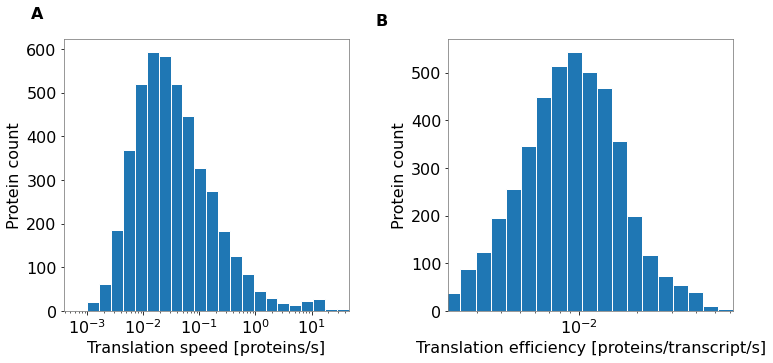

In [84]:
print("Protein speeds per transcript:")
t = PrettyTable(["Ribosomes", 'Min', '25%', 'Median', '75%', 'Max'])
for nribo in results.keys():
    t.add_row([nribo] + list(fivenum(prot_per_transcript_speeds[nribo].values())))
print(t)
plot_speed_efficiency(prot_speeds[nribo], prot_per_transcript_speeds[nribo])